In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
r_data = pd.read_csv("reddit_wsb.csv")

In [3]:
title_data = r_data[['title','timestamp']].copy()
body_data = r_data[['body','timestamp']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()


title_data.title = title_data.title.str.lower()
body_data.body = body_data.body.str.lower()

#Remove handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
title_data.title = title_data.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#Remove Time From Timestamp
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
body_data.timestamp = pd.to_datetime(body_data.timestamp).dt.date

In [4]:
sid = SIA()
# body_data['sentiments']           = body_data['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
# body_data['Positive Sentiment']   = body_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
# body_data['Neutral Sentiment']    = body_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
# body_data['Negative Sentiment']   = body_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

# body_data.drop(columns=['sentiments'],inplace=True)


title_data['sentiments']           = title_data['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
title_data['Positive Sentiment']   = title_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
title_data['Neutral Sentiment']    = title_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
title_data['Negative Sentiment']   = title_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

title_data.drop(columns=['sentiments'],inplace=True)

In [5]:
title_data.head()

,title,timestamp,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,itnot about the money itabout sendingmessage,2021-01-28,0.000001,1.000001,0.000001
1,math professor scott steiner says the numbers ...,2021-01-28,0.000001,0.728001,0.272001
2,exit the system,2021-01-28,0.000001,1.000001,0.000001
3,new sec filing for gme can someone less retard...,2021-01-28,0.138001,0.658001,0.204001
4,not to distract from gme just thought our amc ...,2021-01-28,0.119001,0.881001,0.000001


In [6]:
# creating class from sentiment values
title_data['class_name'] = title_data[['Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']].idxmax(axis=1)

In [7]:
# removing neutral class from reducing bias
data = title_data[title_data['class_name'] != 'Neutral Sentiment']
data.reset_index(drop=True, inplace=True)
data.head(5)

,title,timestamp,Positive Sentiment,Neutral Sentiment,Negative Sentiment,class_name
0,i love you retards,2021-01-28,0.677001,0.323001,0.000001,Positive Sentiment
1,the wallstreetbets war museum,2021-01-28,0.000001,0.435001,0.565001,Negative Sentiment
2,this took me longer thand like to admit enjoy ...,2021-01-28,0.517001,0.483001,0.000001,Positive Sentiment
3,most recent short interest,2021-01-28,0.521001,0.479001,0.000001,Positive Sentiment
4,charitably minded autists,2021-01-28,0.545001,0.455001,0.000001,Positive Sentiment


In [8]:
# total number of positive and negative sentiments
l = len(data[data['class_name'] == 'Negative Sentiment'])
print(f"There are {l} negative sentences")

m = len(data[data['class_name'] == 'Positive Sentiment'])
print(f"There are {m} positive sentences")

There are 1196 negative sentences
There are 1456 positive sentences


In [9]:
# replacing negative and positive sentiment in class with '0' and '1'
data['class_name'][data['class_name'] == 'Negative Sentiment'] = 0
data['class_name'][data['class_name'] == 'Positive Sentiment'] = 1

data.rename(columns={'class_name':'class'}, inplace=True)

Text(0, 0.5, 'Negative')

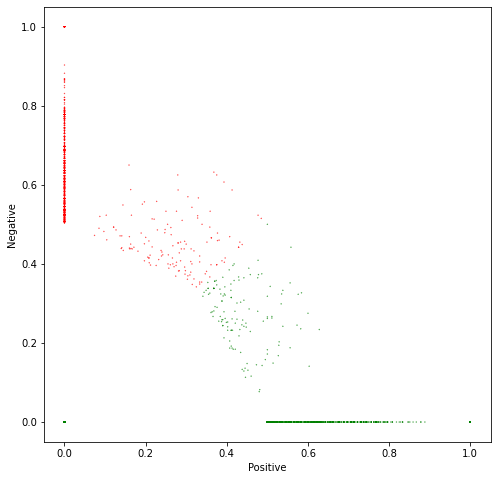

In [10]:
X = data[['Positive Sentiment', 'Negative Sentiment']].values
Y = data['class'].values;

fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red' , 'green']

# Color based on the sentiment Y
ax.scatter(X[:,0], X[:,1], c=[colors[int(k)] for k in Y], s=0.1)
plt.xlabel("Positive")
plt.ylabel("Negative")

# Graph shows that the positive and negative sentiments are majorly separated so theaccuracy should be high

In [11]:
data = data[['title','class']].copy()
data.head()

,title,class
0,i love you retards,1
1,the wallstreetbets war museum,0
2,this took me longer thand like to admit enjoy ...,1
3,most recent short interest,1
4,charitably minded autists,1


## Approach 1 : Sorted classes

In [12]:
split_ratio = int(len(data) * 0.8)
train_x = data['title'][:split_ratio]
test_x = data['title'][split_ratio:]
train_y = data['class'][:split_ratio]
test_y = data['class'][split_ratio:]

In [13]:
print(type(train_y),
type(train_x),
type(test_y),
type(test_x))

train_y = np.asarray(train_y, dtype='int32')
test_y = np.asarray(test_y, dtype='int32')

train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1,1)

print(type(train_y),
type(train_x),
type(test_y),
type(test_x))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [14]:
def preprocess(sentence):
    
    sentence = sentence.lower()
    stemmer = PorterStemmer()
    
    tokenized = word_tokenize(sentence)
    cleaned_list = []
    
    stopwords_english = stopwords.words('english')
    
    for word in tokenized:
        if (word not in stopwords_english and word not in string.punctuation):
            stem_word = stemmer.stem(word)  
            cleaned_list.append(stem_word)
            
    return cleaned_list

In [15]:
def build_freqs(sentences, ys):

    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, sentence in zip(yslist, sentences):
        for word in preprocess(sentence):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

freqs = build_freqs(train_x, train_y)

In [16]:
def sigmoid(z): 
    return (1 / (1 + np.exp(-z)))

In [17]:
def gradientDescent(x, y, theta, alpha, num_iters):

    m = len(x)
    
    for i in range(0, num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)
        
        J = (-1/m) * (np.dot((y.T), np.log(h)) + np.dot((1 - y).T, np.log(1 - h))) 
        
        theta = theta - (alpha/m) * np.dot(x.T, (h - y))
        
        if i % (num_iters) == 0:
            print(i, J)
    
    J = float(J)
    
    return J, theta

In [18]:
def extract_features(sentence, freqs):

    word_l = preprocess(sentence)
    x = np.zeros((1, 3)) 
    
    x[0,0] = 1 
    
    for word in word_l:            
        x[0,1] += freqs[(word, 1)] if (word, 1) in freqs else 0
        
        x[0,2] += freqs[(word, 0)] if (word, 0.0) in freqs else 0 

    return x

In [19]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

Y = train_y

J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-5, 15000)

print(f"The cost after training is {J:.8f}.")

print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

0 [[0.69314718]]
The cost after training is 0.41509890.
The resulting vector of weights is [0.00140395, 0.05147941, -0.04059462]


In [20]:
def predict(sentence, freqs, theta):

    x = extract_features(sentence, freqs)

    y_pred = sigmoid(np.dot(x, theta))
    
    return y_pred

In [21]:
for text in ['I am happy', 'very bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (text, predict(text, freqs, theta)))

I am happy -> 0.515937
very bad -> 0.415280
this movie should have been great. -> 0.718881
great -> 0.708361
great great -> 0.854889
great great great -> 0.934595
great great great great -> 0.971956


In [22]:
def test_logistic_regression(test_x, test_y, freqs, theta):

    y_hat = []
    
    for sentence in test_x:
        y_pred = predict(sentence, freqs, theta)
        
        if y_pred > 0.5:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)

    accuracy = (np.array((y_hat)) == np.squeeze(test_y)).mean()

    return accuracy

tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.8776


In [23]:
title = 'Gamestop sucks'
print(preprocess(title))
y_hat = predict(title, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['gamestop', 'suck']
[[0.48623569]]
Negative sentiment
